In [1]:
# ============================================
# 1) IMPORT LIBRARY
# ============================================
import pandas as pd
import random
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
import torch
from datasets import Dataset


import torch
from torch import nn

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
# ==================================================
# 2) BACA DATA
# ==================================================
df = pd.read_csv("/content/cleaned_for_training_final (3).csv")

print("\n=== Step 2: Dataset Loaded ===")
print("Jumlah total data :", len(df))
print("\nDistribusi Label (SEBELUM SPLIT):")
print(df['label'].value_counts())
print("\nPersentase Label (SEBELUM SPLIT):")
print((df['label'].value_counts(normalize=True) * 100).round(4))



=== Step 2: Dataset Loaded ===
Jumlah total data : 7178

Distribusi Label (SEBELUM SPLIT):
label
0    4374
1    2804
Name: count, dtype: int64

Persentase Label (SEBELUM SPLIT):
label
0    60.9362
1    39.0638
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# ==================================================
# 3) SPLIT DATA (70:15:15) DENGAN STRATIFY
# ==================================================
train_df, test_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df["label"]
)

train_df, valid_df = train_test_split(
    train_df,
    test_size=0.1765,
    random_state=42,
    stratify=train_df["label"]
)

print("Train:", len(train_df), "Valid:", len(valid_df), "Test:", len(test_df))
print("Distribusi label train sebelum PROS:")
print(train_df["label"].value_counts(), "\n")


Train: 5024 Valid: 1077 Test: 1077
Distribusi label train sebelum PROS:
label
0    3062
1    1962
Name: count, dtype: int64 



In [ ]:
from collections import Counter
import pandas as pd

def apply_PROS(df, label="label", target_ratio=1.5, seed=42):
    counter = df[label].value_counts()
    minority = counter.idxmin()
    majority = counter.idxmax()

    df_min = df[df[label] == minority]
    df_maj = df[df[label] == majority]

    target_min_size = int(len(df_maj) / target_ratio)

    if target_min_size <= len(df_min):
        return df.sample(frac=1, random_state=seed).reset_index(drop=True)

    df_min_over = df_min.sample(n=target_min_size, replace=True, random_state=seed)
    return pd.concat([df_maj, df_min_over]).sample(frac=1, random_state=seed).reset_index(drop=True)


# ==================================================
# PROS DIAPLIKASIKAN KE TRAIN
# Catatan:
# - target_ratio -> (1.5:1)
# 
# ==================================================

train_pros = apply_PROS(train_df, label="label", target_ratio=1.5, seed=42)
print(train_pros["label"].value_counts().sort_index())


print("Distribusi label TRAIN sebelum PROS:")
print(train_df["label"].value_counts().sort_index(), "\n")

print("Distribusi label TRAIN sesudah PROS:")
print(train_pros["label"].value_counts().sort_index(), "\n")

print("Persentase sesudah PROS:")
print((train_pros["label"].value_counts(normalize=True).sort_index() * 100).round(2))


label
0    3062
1    2041
Name: count, dtype: int64
Distribusi label TRAIN sebelum PROS:
label
0    3062
1    1962
Name: count, dtype: int64 

Distribusi label TRAIN sesudah PROS:
label
0    3062
1    2041
Name: count, dtype: int64 

Persentase sesudah PROS:
label
0    60.0
1    40.0
Name: proportion, dtype: float64


In [26]:
# ==================================================
# 6) CLASS WEIGHT BERDASARKAN TRAIN_PROS
# ==================================================
labels_pros = train_pros["label"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_pros),
    y=labels_pros
)

# override manual
class_weights[0] = 1.0
class_weights[1] = 1.2

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

print(class_weights_tensor)

tensor([1.0000, 1.2000], device='cuda:0')


In [27]:
# ============================================
# 6) TOKENIZER
# ============================================
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [28]:
def tokenize_function(batch):
    return tokenizer(
        batch["clean_text"],          # pastikan nama kolom ini ada di CSV
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [29]:
from datasets import Dataset

# ==================================================
# 8) CONVERT PANDAS → HF DATASET
# ==================================================
# TRAIN (PROS)
train_ds = Dataset.from_pandas(train_pros.reset_index(drop=True))
train_ds = train_ds.map(tokenize_function, batched=True)
train_ds = train_ds.remove_columns(
    [c for c in train_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# VALID
valid_ds = Dataset.from_pandas(valid_df.reset_index(drop=True))
valid_ds = valid_ds.map(tokenize_function, batched=True)
valid_ds = valid_ds.remove_columns(
    [c for c in valid_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
valid_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# TEST
test_ds = Dataset.from_pandas(test_df.reset_index(drop=True))
test_ds = test_ds.map(tokenize_function, batched=True)
test_ds = test_ds.remove_columns(
    [c for c in test_ds.column_names if c not in ["input_ids", "attention_mask", "label"]]
)
test_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])



Map:   0%|          | 0/5103 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

Map:   0%|          | 0/1077 [00:00<?, ? examples/s]

In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1_macro, _ = precision_recall_fscore_support(
        labels, preds,
        average="macro",
        zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1_macro": f1_macro,
    }

In [31]:
# ============================================
# 8) WEIGHT TENSOR & WEIGHTED TRAINER
# ============================================
from transformers import Trainer
import torch.nn as nn
import torch

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=0):
        labels = inputs.get("labels")

        # Hapus labels sebelum masuk ke model
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"]
        )

        logits = outputs.get("logits")

        # CrossEntropyLoss dengan class weight
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits, labels)

        # FIX return
        if return_outputs:
            return loss, outputs
        else:
            return loss


In [ ]:
import itertools
import random
import torch

# Ruang hyperparameter
search_space = {
    "learning_rate": [1e-5, 2e-5, 3e-5, 5e-5],
    "batch_size": [8, 16, 32],
    "num_train_epochs": [3, 4, 5]
}

# Buat semua kombinasi (lr, bs, ep) → anti duplikasi
all_combos = list(itertools.product(
    search_space["learning_rate"],
    search_space["batch_size"],
    search_space["num_train_epochs"]
))

random.shuffle(all_combos)   # acak urutan kombinasi

N_TRIALS = 8   # jumlah percobaan yang mau dicoba
all_combos = all_combos[:N_TRIALS]   # ambil N_TRIALS kombinasi pertama



In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, EarlyStoppingCallback
import random

model_name = "indolem/indobertweet-base-uncased"
best_f1 = 0.0
best_params = None
results = []

# misal all_combos sudah kamu buat dan dibatasi N_TRIALS
# all_combos = [...]
# all_combos = all_combos[:N_TRIALS]

for i, (lr, bs, ep) in enumerate(all_combos, start=1):
    print(f"\n==================== Percobaan {i} ====================")
    print(f"lr={lr}, bs={bs}, epoch={ep}")

    # reset model tiap trial
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2
    ).to(device)

    args = TrainingArguments(
        output_dir=f"./tmp_indobertweet_prus_classweight_trial_{i}",
        learning_rate=lr,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        num_train_epochs=ep,
        eval_strategy="epoch",      # ✅ perbaiki ini
        logging_strategy="epoch",
        save_strategy="no",
        load_best_model_at_end=False,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        report_to="none",
        seed=42
    )

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=valid_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        class_weights=class_weights_tensor,   # ✅ nama argumen sesuai __init__
        callbacks=[
            EarlyStoppingCallback(
                early_stopping_patience=2,
                early_stopping_threshold=0.0
            )
        ]
    )

    trainer.train()

    # ambil log per epoch
    history = trainer.state.log_history
    f1_per_epoch = [h["eval_f1_macro"] for h in history if "eval_f1_macro" in h]
    best_f1_trial = max(f1_per_epoch)
    best_epoch_idx = f1_per_epoch.index(best_f1_trial) + 1

    results.append({
        "trial": i,
        "learning_rate": lr,
        "batch_size": bs,
        "num_train_epochs": ep,
        "best_epoch": best_epoch_idx,
        "f1_macro": best_f1_trial
    })

    print(f"➡️ F1 Macro terbaik percobaan {i}: {best_f1_trial:.4f} (epoch {best_epoch_idx})")

    if best_f1_trial > best_f1:
        best_f1 = best_f1_trial
        best_params = {
            "learning_rate": lr,
            "batch_size": bs,
            "num_train_epochs": ep,
            "best_epoch": best_epoch_idx
        }

print("\n==================== Hasil Random Search (PRUS + Class Weight) ====================")
print("BEST:", best_params)
print("BEST F1:", best_f1)


==================== Percobaan 1 ====================
lr=1e-05, bs=32, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.496700,0.442828,0.796657,0.789852,0.802447,0.792068
2,0.353700,0.453692,0.811513,0.804578,0.817620,0.807150
3,0.284800,0.462449,0.822656,0.813564,0.822937,0.816834
4,0.231000,0.493050,0.819870,0.810417,0.818098,0.813370
5,0.203600,0.505641,0.816156,0.806522,0.813347,0.809245


➡️ F1 Macro terbaik percobaan 1: 0.8168 (epoch 3)

==================== Percobaan 2 ====================
lr=2e-05, bs=16, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.450100,0.457158,0.805942,0.803931,0.819003,0.803162
2,0.266500,0.519994,0.821727,0.812969,0.823451,0.816307
3,0.158500,0.626911,0.824513,0.817041,0.812123,0.814348
4,0.095400,0.802058,0.837512,0.828482,0.834281,0.830962
5,0.059400,0.876243,0.833798,0.826000,0.824000,0.824960


➡️ F1 Macro terbaik percobaan 2: 0.8310 (epoch 4)

==================== Percobaan 3 ====================
lr=5e-05, bs=16, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.433100,0.439520,0.811513,0.807492,0.822300,0.808274
2,0.218500,0.578200,0.833798,0.827395,0.821022,0.823845
3,0.090800,0.873222,0.825441,0.820991,0.808206,0.813266
4,0.036000,1.055308,0.823584,0.814151,0.818594,0.816119


➡️ F1 Macro terbaik percobaan 3: 0.8238 (epoch 2)

==================== Percobaan 4 ====================
lr=5e-05, bs=16, epoch=4


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.432300,0.453395,0.806871,0.802998,0.817638,0.803599
2,0.209400,0.768505,0.820799,0.812898,0.808649,0.810593
3,0.094400,0.885861,0.818942,0.809322,0.814783,0.811643
4,0.034800,1.028178,0.822656,0.815257,0.809748,0.812211


➡️ F1 Macro terbaik percobaan 4: 0.8122 (epoch 4)

==================== Percobaan 5 ====================
lr=3e-05, bs=32, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.437400,0.446069,0.802228,0.801728,0.816805,0.799742
2,0.233900,0.504065,0.818942,0.810326,0.821165,0.813619
3,0.118900,0.648224,0.827298,0.818786,0.818239,0.818509
4,0.068500,0.794906,0.836583,0.830753,0.823308,0.826552
5,0.040500,0.833177,0.831941,0.824563,0.820774,0.822530


➡️ F1 Macro terbaik percobaan 5: 0.8266 (epoch 4)

==================== Percobaan 6 ====================
lr=5e-05, bs=8, epoch=5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.449300,0.538552,0.815227,0.808769,0.822371,0.811163
2,0.234600,0.739783,0.824513,0.815069,0.821058,0.817577
3,0.115800,1.017535,0.819870,0.814599,0.802782,0.807501
4,0.046000,1.220356,0.834726,0.827621,0.823486,0.825393
5,0.018400,1.276995,0.832869,0.826285,0.820260,0.822943


➡️ F1 Macro terbaik percobaan 6: 0.8254 (epoch 4)

==================== Percobaan 7 ====================
lr=3e-05, bs=32, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.446800,0.416325,0.827298,0.818338,0.828025,0.821690
2,0.251500,0.474116,0.815227,0.808104,0.821094,0.810841
3,0.150800,0.550954,0.819870,0.810331,0.814269,0.812101


➡️ F1 Macro terbaik percobaan 7: 0.8217 (epoch 1)

==================== Percobaan 8 ====================
lr=2e-05, bs=32, epoch=3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.459500,0.419778,0.814299,0.805092,0.814376,0.808269
2,0.289900,0.476684,0.806871,0.800485,0.813809,0.802678
3,0.211800,0.502484,0.823584,0.814128,0.819019,0.816262


➡️ F1 Macro terbaik percobaan 8: 0.8163 (epoch 3)

==================== Hasil Random Search (PRUS + Class Weight) ====================
BEST: {'learning_rate': 2e-05, 'batch_size': 16, 'num_train_epochs': 5, 'best_epoch': 4}
BEST F1: 0.8309618515047288


In [ ]:
import pandas as pd

log_hist = pd.DataFrame(trainer.state.log_history)


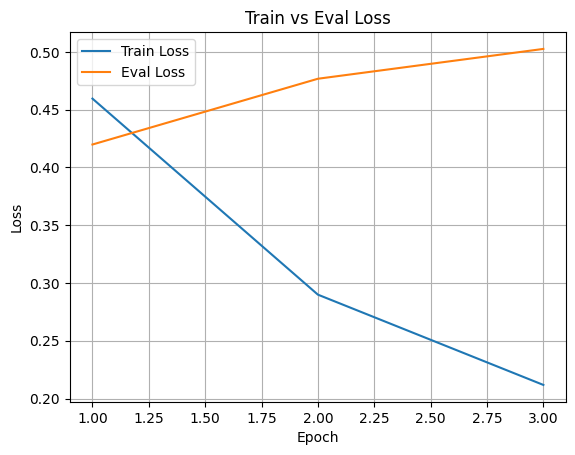

In [ ]:
import matplotlib.pyplot as plt

# Filter for training logs (where 'loss' is present)
train_logs = log_hist[log_hist["loss"].notna()]
# Filter for evaluation logs (where 'eval_loss' is present)
eval_logs = log_hist[log_hist["eval_loss"].notna()]

plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid(True)
plt.show()

Manual

In [32]:
best_params = {'learning_rate': 2e-05, 'batch_size': 16}
print("Defined best_params:", best_params)

Defined best_params: {'learning_rate': 2e-05, 'batch_size': 16}


In [33]:
from transformers import (
    AutoModelForSequenceClassification,
    TrainingArguments,
    EarlyStoppingCallback,
)

# ambil hyperparameter terbaik dari random search
best_lr     = best_params["learning_rate"]
best_bs     = best_params["batch_size"]

print("Best params:", best_params)

# model baru untuk training final
model_final = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
).to(device)

args_final = TrainingArguments(
    output_dir="./indobertweet_prus_classweight_best",
    learning_rate=best_lr,
    per_device_train_batch_size=best_bs,
    per_device_eval_batch_size=best_bs,
    num_train_epochs=3,          # train sampai epoch optimal
    eval_strategy="epoch",          # ✅ diperbaiki
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    weight_decay=0.01,                    # regularisasi biar ga makin overfit
    report_to="none",
    seed=42,
)

trainer_final = WeightedTrainer(
    model=model_final,
    args=args_final,
    train_dataset=train_ds,               # pastikan ini sudah PRUS
    eval_dataset=valid_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights_tensor,          # untuk class weight
    callbacks=[
        EarlyStoppingCallback(
            early_stopping_patience=2    # stop cepat kalau mulai overfit
        )
    ]
)

trainer_final.train()

# simpan model & tokenizer buat dipakai lagi / lampiran skripsi
save_dir = "./indobertweet_prus_classweight_best"
trainer_final.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model final disimpan di:", save_dir)


Best params: {'learning_rate': 2e-05, 'batch_size': 16}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3671470619.py:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1 Macro
1,0.450300,0.425088,0.811513,0.803240,0.814642,0.806342
2,0.276900,0.463840,0.825441,0.816108,0.820118,0.817912
3,0.172800,0.592150,0.828227,0.820617,0.816874,0.818608


Model final disimpan di: ./indobertweet_prus_classweight_best


In [34]:
import pandas as pd

# evaluasi
eval_valid = trainer_final.evaluate(eval_dataset=valid_ds)
eval_test  = trainer_final.evaluate(eval_dataset=test_ds)

# pilih metrik yang mau ditampilkan
keep_keys = [
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]

def filter_metrics(dct, name):
    data = {"Dataset": name}
    for k in keep_keys:
        data[k] = dct.get(k, None)
    return data

rows = [
    filter_metrics(eval_valid, "Valid"),
    filter_metrics(eval_test,  "Test")
]

df_eval = pd.DataFrame(rows)

# urutkan kolom + rename biar lebih enak dibaca
df_eval = df_eval[[
    "Dataset",
    "eval_loss",
    "eval_accuracy",
    "eval_precision",
    "eval_recall",
    "eval_f1_macro",
    "epoch"
]].rename(columns={
    "eval_loss": "Loss",
    "eval_accuracy": "Accuracy",
    "eval_precision": "Precision",
    "eval_recall": "Recall",
    "eval_f1_macro": "F1 Macro",
    "epoch": "Epoch"
})

# bulatkan 4 desimal untuk metrik numerik
for col in ["Loss", "Accuracy", "Precision", "Recall", "F1 Macro"]:
    df_eval[col] = df_eval[col].astype(float).round(4)

df_eval = df_eval.set_index("Dataset")
df_eval


,Loss,Accuracy,Precision,Recall,F1 Macro,Epoch
Dataset,,,,,,
Valid,0.5921,0.8282,0.8206,0.8169,0.8186,3.0
Test,0.5520,0.8394,0.8323,0.8290,0.8305,3.0


In [36]:
import pandas as pd

log_hist = pd.DataFrame(trainer_final.state.log_history)


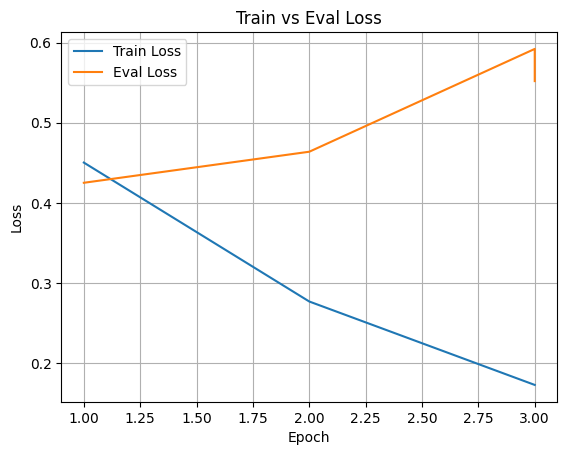

In [37]:
import matplotlib.pyplot as plt

# Filter for training logs (where 'loss' is present)
train_logs = log_hist[log_hist["loss"].notna()]
# Filter for evaluation logs (where 'eval_loss' is present)
eval_logs = log_hist[log_hist["eval_loss"].notna()]

plt.plot(train_logs["epoch"], train_logs["loss"], label="Train Loss")
plt.plot(eval_logs["epoch"], eval_logs["eval_loss"], label="Eval Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid(True)
plt.show()

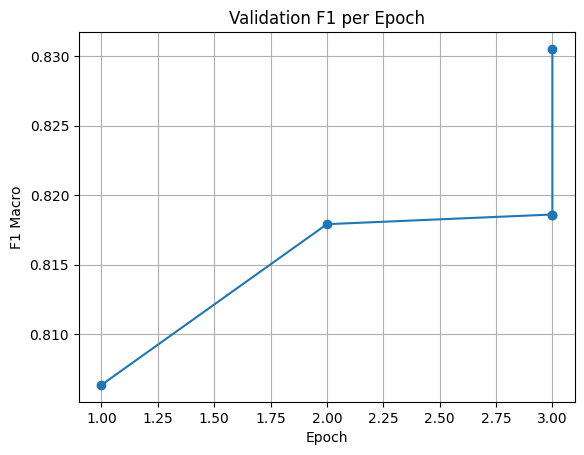

In [38]:
eval_f1 = log_hist[log_hist["eval_f1_macro"].notna()]

plt.plot(eval_f1["epoch"], eval_f1["eval_f1_macro"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("F1 Macro")
plt.title("Validation F1 per Epoch")
plt.grid(True)
plt.show()



📊 Classification Report (TEST):
              precision    recall  f1-score   support

non-sarkasme     0.8621    0.8765    0.8692       656
    sarkasme     0.8024    0.7815    0.7918       421

    accuracy                         0.8394      1077
   macro avg     0.8323    0.8290    0.8305      1077
weighted avg     0.8388    0.8394    0.8390      1077



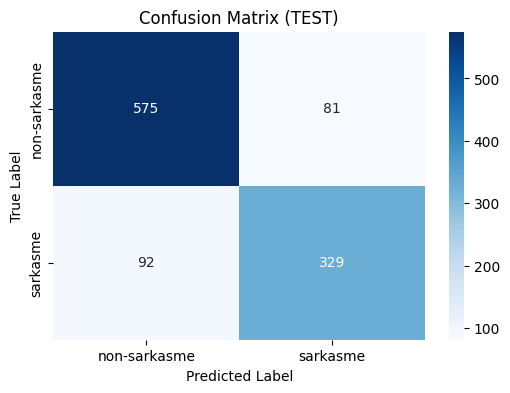

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

pred_test = trainer_final.predict(test_ds)
y_pred = np.argmax(pred_test.predictions, axis=1)
y_true = pred_test.label_ids

# Print classification report
print("\n📊 Classification Report (TEST):")
print(classification_report(y_true, y_pred, target_names=["non-sarkasme", "sarkasme"], digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["non-sarkasme", "sarkasme"],
            yticklabels=["non-sarkasme", "sarkasme"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (TEST)")
plt.show()

In [ ]:
save_dir = "./model_pros_final"

trainer_final.save_model(save_dir)
tokenizer.save_pretrained(save_dir)

print("Model & tokenizer disimpan ke:", save_dir)


Model & tokenizer disimpan ke: ./model_pros_final


Visualisasi

ROC–AUC Score: 0.9255


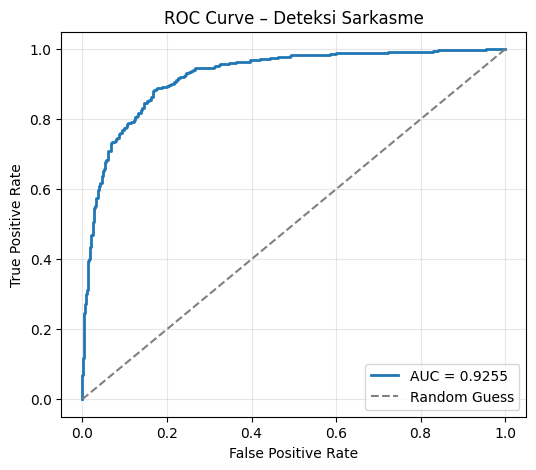

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

pred_test = trainer_final.predict(test_ds)
logits = pred_test.predictions
y_true = pred_test.label_ids

probs = np.exp(logits) / np.exp(logits).sum(axis=1, keepdims=True)
y_score = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

print(f"ROC–AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.title("ROC Curve – Deteksi Sarkasme")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


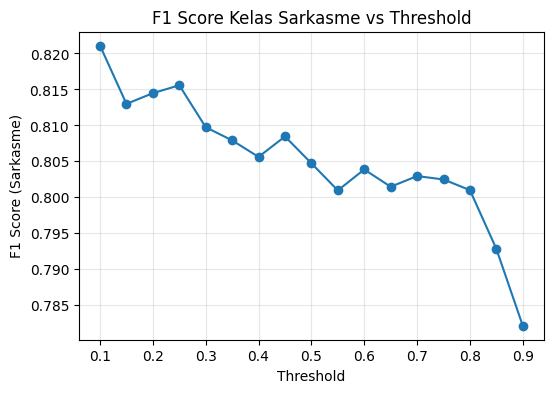

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(df_thresh["threshold"], df_thresh["f1_sarkas"], marker="o")
plt.title("F1 Score Kelas Sarkasme vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Sarkasme)")
plt.grid(alpha=0.3)
plt.show()


In [ ]:
sentences = [
    "Bagus banget nih! Luar biasa! aku juga mau #kaburajadulu ke thailand",
    "pemerintah udah #kaburajadulu masalah negara, kita kapan?",
    "kapan ya bisa #kaburajadulu",
    "Pemerintah selalu bikin rakyat sengasara #kaburajadulu"]

inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)
outputs = model_final(**inputs)
preds = outputs.logits.argmax(dim=1)

for s, p in zip(sentences, preds):
    print(s, "=>", "Sarkasme" if p.item()==1 else "Non-Sarkasme")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Bagus banget nih! Luar biasa! aku juga mau #kaburajadulu ke thailand => Non-Sarkasme
pemerintah udah #kaburajadulu masalah negara, kita kapan? => Sarkasme
kapan ya bisa #kaburajadulu => Non-Sarkasme
Pemerintah selalu bikin rakyat sengasara #kaburajadulu => Sarkasme


BATAS